In [ ]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend
from matplotlib import pyplot as plt
from voxelwise_tutorials.io import load_hdf5_array
from voxelwise_tutorials.viz import plot_flatmap_from_mapper

from fmri.results import get_result_path

In [ ]:
backend = set_backend("torch_cuda")
data_dir = "../../data"


In [ ]:
subject = 5
modality = 'listening'
low_level_feature = "powspec"

In [ ]:
mapper_path = os.path.join("../../data", 'mappers', f"subject{subject:02}_mappers.hdf")
mapper = load_hdf5_array(mapper_path)
flatmap_mask = mapper["flatmap_mask"]
mapper.keys()

# Scatter AC

In [ ]:
mapper = load_hdf5_array(mapper_path)
ac_mask = mapper['roi_mask_AC']
# set all values > 0 to 1
ac_mask[ac_mask > 0] = 1
ac_mask = ac_mask.astype(bool)

sns.histplot(ac_mask, kde=False, bins=50)
plt.yscale('log')
viewport_size = 450
fig, axs = plt.subplots(2, 1, figsize=(viewport_size / 100, viewport_size / 100))

cmap = 'magma'
alpha = 1

width = flatmap_mask.shape[0]
height = flatmap_mask.shape[1]
vcenter = 2 * height / 3
hcenter = width / 2

left_ac = hcenter - 500
right_ac = hcenter + 450
vac = 650

for row, ac in enumerate([left_ac, right_ac]):
    ax = axs[row]
    plot_flatmap_from_mapper(ac_mask, mapper_path, vmin=0, vmax=all_masks.max(), ax=ax, with_colorbar=False)

    ax.axis('off')
    ax.set_xlim([ac - viewport_size / 2, ac + viewport_size / 2])
    ax.set_ylim([vac + viewport_size / 4, vac - viewport_size / 4])

fig.text(0, .65, "LH", rotation=90, horizontalalignment='left', weight='bold')
fig.text(0, .25, "RH", rotation=90, horizontalalignment='left', weight='bold')

plt.tight_layout()
plt.subplots_adjust(hspace=0)
# create all pairwise scatterplots in visualcorteces for semantic, variance partitioning, residual method ols and residual method ridge
data = pd.DataFrame()

auditory_semantic = semantic_correlation[ac_mask]
auditory_rm = residual_correlation[ac_mask]
auditory_rm_ridge = residual_ridge_correlation[ac_mask]
auditory_vp = vp_correlation[ac_mask]

data["Residual Method (Ridge)"] = auditory_rm_ridge
data["Residual Method (OLS)"] = auditory_rm
data["Variance Partioning"] = auditory_vp
data["Semantic"] = auditory_semantic
vmax = data.max().max()
vmin = data.min().min()
print(vmin, vmax)
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for ax, col in zip(axs, data.columns):
    sns.scatterplot(data, x=col, y="Semantic", ax=ax, alpha=0.2)
    sns.lineplot(x=[vmin, vmax], y=[vmin, vmax], linestyle='--', ax=ax)
g = sns.pairplot(data, corner=True, plot_kws=dict(alpha=0.2))

# Loop through the axes
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        # Apply same x and y limits to all axes
        if ax is not None:
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)

            if i != j:  # Only modify non-diagonal plots
                sns.lineplot(
                    x=[vmin, vmax],
                    y=[vmin, vmax],
                    ax=ax,
                    # color="red",
                    linestyle="dashed"
                )

# mask out early ac

In [ ]:
semantic_listening_path = os.path.join(get_result_path('listening', subject), "english1000_scores.csv")
semantic_reading_path = os.path.join(get_result_path('reading', subject), "english1000_scores.csv")

semantic_listening = pd.read_csv(semantic_listening_path)
semantic_reading = pd.read_csv(semantic_reading_path)

semantic_listening_corr = np.array(semantic_listening["correlation_score"])
semantic_reading_corr = np.array(semantic_reading["correlation_score"])

In [ ]:
ac_mask = mapper["roi_mask_AC"]
ac_mask = np.bool(ac_mask)

By subtracting activity during reading from listening, only the early ac should contain positive values

In [ ]:
listening_minus_reading = semantic_listening_corr - semantic_reading_corr
thresh = 0.1
subtract_semantic_early_ac_mask = listening_minus_reading > thresh
subtract_semantic_early_ac_mask = subtract_semantic_early_ac_mask & ac_mask

Using EV

In [ ]:
ev_listening = np.loadtxt(get_result_path('listening', subject) + "/ev.csv", delimiter=",", skiprows=1)
ev_reading = np.loadtxt(get_result_path('reading', subject) + "/ev.csv", delimiter=",", skiprows=1)

In [ ]:
subtract_ev_early_ac_mask = ev_listening - ev_reading
thresh = 0.1
subtract_ev_early_ac_mask = subtract_ev_early_ac_mask > thresh
subtract_ev_early_ac_mask = subtract_ev_early_ac_mask & ac_mask

Values that are high in one and low in the other

In [ ]:
thresh_semantic_early_ac_mask = (semantic_listening_corr > thresh) & (semantic_reading_corr < thresh)
thresh_semantic_early_ac_mask = thresh_semantic_early_ac_mask & ac_mask

In [ ]:
thresh_ev_early_ac_mask = (ev_listening > thresh) & (ev_reading < thresh)
thresh_ev_early_ac_mask = thresh_ev_early_ac_mask & ac_mask
plot_flatmap_from_mapper(thresh_ev_early_ac_mask, mapper_path, vmin=0, vmax=1)

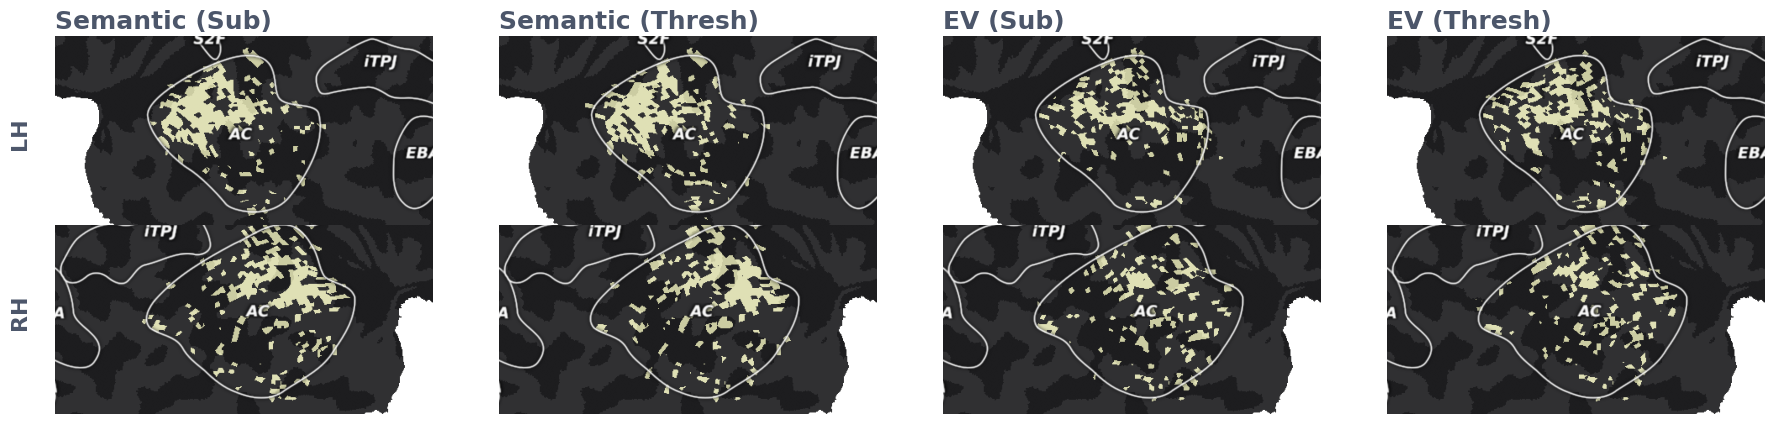

In [46]:
viewport_size = 450
fig, axs = plt.subplots(2, 4, figsize=(viewport_size / 100 * 4, viewport_size / 100))

cmap = 'magma'
alpha = 0.7

width = flatmap_mask.shape[0]
height = flatmap_mask.shape[1]
vcenter = 2 * height / 3
hcenter = width / 2

left_ac = hcenter - 500
right_ac = hcenter + 450
vac = 650

for row, ac in enumerate([left_ac, right_ac]):
    for col, (corr, name) in enumerate(
            zip([subtract_semantic_early_ac_mask, thresh_semantic_early_ac_mask, subtract_ev_early_ac_mask,
                 thresh_ev_early_ac_mask],
                ["Semantic (Sub)", "Semantic (Thresh)", "EV (Sub)", "EV (Thresh)"])):
        ax = axs[row, col]

        ax.axis('off')
        ax.set_xlim([ac - viewport_size / 2, ac + viewport_size / 2])
        ax.set_ylim([vac + viewport_size / 4, vac - viewport_size / 4])

        if row == 0:
            ax.set_title(name)

        plot_flatmap_from_mapper(corr, mapper_path, ax=ax, vmin=0, vmax=1, with_colorbar=False, cmap=cmap,
                                 alpha=alpha)

fig.text(0, .65, "LH", rotation=90, horizontalalignment='left', weight='bold')
fig.text(0, .25, "RH", rotation=90, horizontalalignment='left', weight='bold')

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()

# Plot predicted activity in early ac

In [47]:
early_ac_mask = subtract_semantic_early_ac_mask

In [49]:
result_path = get_result_path(modality, subject)
semantic_path = os.path.join(result_path, f"english1000_scores.csv")
vp_path = os.path.join(result_path, f"vp_english1000_{low_level_feature}_scores.csv")
rm_path = os.path.join(result_path, f"residual_{low_level_feature}_english1000_scores.csv")
rm_ridge_path = os.path.join(result_path, f"residual_ridge_{low_level_feature}_english1000_scores.csv")

In [50]:
semantic_scores = pd.read_csv(semantic_path)
vp_scores = pd.read_csv(vp_path)
rm_scores = pd.read_csv(rm_path)
rm_ridge_scores = pd.read_csv(rm_ridge_path)

In [51]:
semantic_correlation = semantic_scores["correlation_score"]
vp_correlation = vp_scores[f"semantic\\{low_level_feature}"]
residual_correlation = rm_scores["correlation_score"]
residual_ridge_correlation = rm_ridge_scores["correlation_score"]

In [53]:
plt.style.use("nord-light-talk")

In [54]:
# create all pairwise scatterplots in visualcorteces for semantic, variance partitioning, residual method ols and residual method ridge
data = pd.DataFrame()

semantic = semantic_correlation[early_ac_mask]
rm = residual_correlation[early_ac_mask]
rm_ridge = residual_ridge_correlation[early_ac_mask]
vp = vp_correlation[early_ac_mask]

data["Residual Method (Ridge)"] = rm_ridge
data["Residual Method (OLS)"] = rm
data["Variance Partitioning"] = vp
data["Semantic"] = semantic
vmax = data.max().max()
vmin = data.min().min()
print(vmin, vmax)

-0.261889238267254 0.4401967840638239


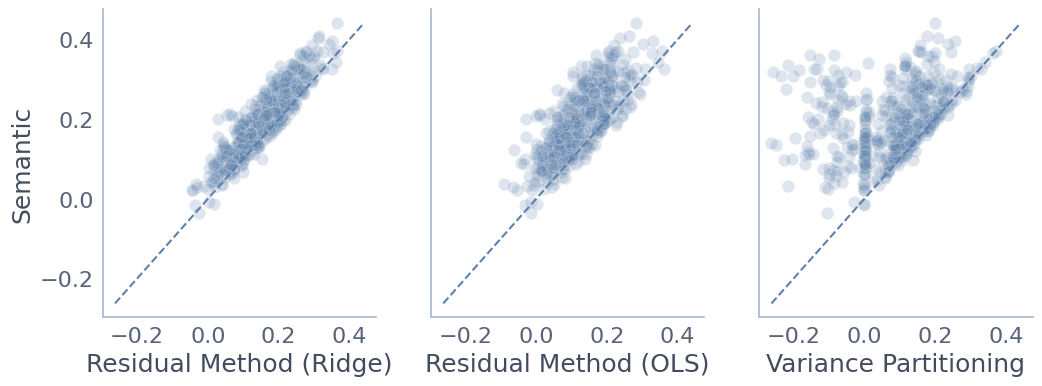

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for ax, col in zip(axs, data.columns):
    sns.scatterplot(data, x=col, y="Semantic", ax=ax, alpha=0.2)
    sns.lineplot(x=[vmin, vmax], y=[vmin, vmax], linestyle='--', ax=ax)